In [1]:
import sys; print(sys.prefix);print(sys.version)


d:\Dropbox\sumi@labKyoto\WorkspaceCl\2025\Intern2_202505GaussProcess\Python\.venv
3.9.21 (main, Feb 12 2025, 14:46:31) [MSC v.1929 64 bit (AMD64)]


In [3]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt

# カスタム関数のimport
import importlib
import src.calc_rmse
importlib.reload(src.calc_rmse)
from src.calc_rmse import calc_rmse  # 再読み込み後に再import
from src.calc_tcr import calc_tcr  # 再読み込み後に再import

# 基本的な使い方

Ctrl + Enter: セルの実行

Ctrl + Shift + minux: セルの分割

「アウトライン（Outline）」ビューの表示
Ctrl+Shift+P → View: Show Outlin

# Gaussian Process のデモコード

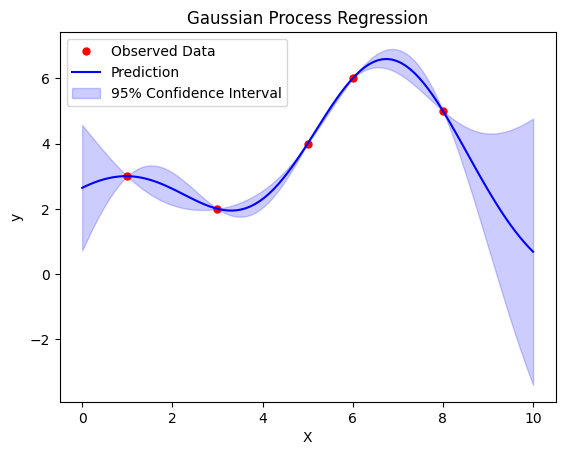

In [4]:
# サンプルデータの生成
X = np.array([[1], [3], [5], [6], [8]])  # 入力データ
y = np.array([3, 2, 4, 6, 5])  # 出力データ

# Gaussian Processのカーネルを定義
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))

# Gaussian Process Regressorの初期化
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# モデルの学習
gp.fit(X, y)

# 予測用データの生成
X_pred = np.linspace(0, 10, 100).reshape(-1, 1)

# 平均と標準偏差を予測
y_pred, sigma = gp.predict(X_pred, return_std=True)

# プロット
plt.figure()
plt.plot(X, y, 'r.', markersize=10, label='Observed Data')
plt.plot(X_pred, y_pred, 'b-', label='Prediction')
plt.fill_between(
    X_pred.ravel(),
    y_pred - 1.96 * sigma,
    y_pred + 1.96 * sigma,
    alpha=0.2,
    color='blue',
    label='95% Confidence Interval'
)
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title('Gaussian Process Regression')
plt.show()

In [5]:
X.shape

(5, 1)

In [6]:
y.shape

(5,)

## GPy のサンプル

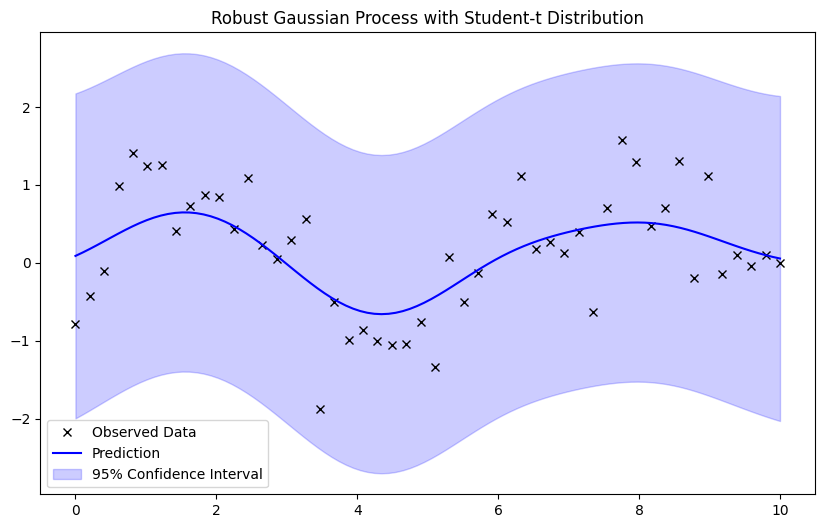

In [50]:
import numpy as np
import GPy

# サンプルデータの生成
X = np.linspace(0, 10, 50)[:, None]
y = np.sin(X) + np.random.normal(0, 0.5, X.shape)

# カーネルの定義
kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)

# Student-t 分布を考慮したガウス過程モデル
# GPy では標準で Student-t 分布をサポートしていないため、ロバストな尤度を使用
model = GPy.models.GPRegression(X, y, kernel)
model.likelihood.variance.fix(1.0)  # 外れ値に強い設定

# モデルの最適化
model.optimize(messages=True)

# 予測
X_pred = np.linspace(0, 10, 100)[:, None]
y_pred, y_var = model.predict(X_pred)

# プロット
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(X, y, 'kx', label='Observed Data')
plt.plot(X_pred, y_pred, 'b-', label='Prediction')
plt.fill_between(
    X_pred.flatten(),
    (y_pred - 1.96 * np.sqrt(y_var)).flatten(),
    (y_pred + 1.96 * np.sqrt(y_var)).flatten(),
    color='blue',
    alpha=0.2,
    label='95% Confidence Interval'
)
plt.legend()
plt.title('Robust Gaussian Process with Student-t Distribution')
plt.show()

# レーダデータによる検証
## レーダデータのローディング

In [30]:
from scipy.io import loadmat
import os

subi = 2
subi = 3
# subi = 4
# subi = 5

data_dir = os.path.abspath(os.path.join(os.getcwd(), 'data'))
print(data_dir)


radar_data_path = os.path.join(data_dir, f'radarIBI_sub{subi}.mat')
ibiECG_path = os.path.join(data_dir, f'ibiECG_sub{subi}.mat')
data = loadmat(radar_data_path)
ibiECG = loadmat(ibiECG_path)



d:\Dropbox\sumi@labKyoto\WorkspaceCl\2025\Intern2_202505GaussProcess\Python\data


In [31]:
radarIBI_time = data['radarIBI']['time']
radarIBI_ibi = data['radarIBI']['ibi']

radarIBI_time = radarIBI_time[0,0].squeeze()
radarIBI_ibi = radarIBI_ibi[0,0].squeeze()


ibiECG_time = ibiECG['ibiECG']['startTime']
ibiECG_ibi = ibiECG['ibiECG']['ibi']
ibiECG_time = ibiECG_time[0,0].squeeze()
ibiECG_ibi = ibiECG_ibi[0,0].squeeze()
print(ibiECG_time.shape)


(277,)


In [37]:
# Time Cut
min_time_s = 0
max_time_s = 160
# min_time_s = 40
# max_time_s = 70
cut_time_range = np.array([min_time_s, max_time_s])

mask = (radarIBI_time >= cut_time_range[0]) & (radarIBI_time <= cut_time_range[1])
radarIBI_time_cut = radarIBI_time[mask]
radarIBI_ibi_cut = radarIBI_ibi[mask]

mas_ecgk = (ibiECG_time >= cut_time_range[0]) & (ibiECG_time <= cut_time_range[1])
ibiECG_time_cut = ibiECG_time[mas_ecgk]
ibiECG_ibi_cut = ibiECG_ibi[mas_ecgk]

print(radarIBI_time_cut.shape)

(445,)


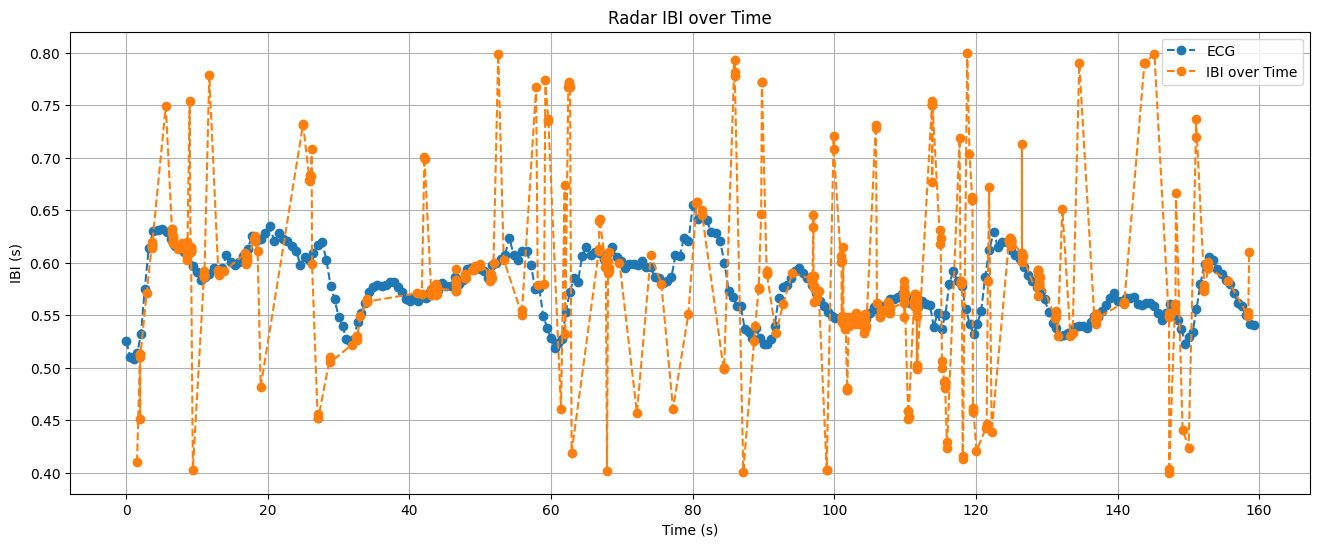

In [39]:
# this_time = radarIBI_time
# this_ibi = radarIBI_ibi
this_time = radarIBI_time_cut

this_ibi = radarIBI_ibi_cut


plt.figure(figsize=(16, 6))
plt.plot(ibiECG_time_cut, ibiECG_ibi_cut, '--o', label='ECG')
plt.plot(this_time, this_ibi, '--o', label='IBI over Time')

plt.xlabel('Time (s)')
plt.ylabel('IBI (s)')
plt.title('Radar IBI over Time')
plt.legend()
plt.grid()
# plt.xlim(0, 160)  # x軸の範囲を0から160に設定
plt.show()

# IBIのガウス過程
## GPy

In [40]:
X = np.linspace(0, 10, 50)[:, None]
y = np.sin(X) + np.random.normal(0, 0.5, X.shape)
y = this_ibi.reshape(-1, 1)
X = this_time.reshape(-1, 1)

print(X.shape)
print(y.shape)

(445, 1)
(445, 1)


In [41]:
# サンプルデータの生成
y = this_ibi.reshape(-1, 1)
X = this_time.reshape(-1, 1)

print(X.shape)
print(y.shape)

# カーネルの定義
kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=5.0)

# Student-t 分布を考慮したガウス過程モデル
# GPy では標準で Student-t 分布をサポートしていないため、ロバストな尤度を使用
model = GPy.models.GPRegression(X, y, kernel)
# model.likelihood.variance.fix(1.0)  # 外れ値に強い設定

# モデルの最適化
model.optimize(messages=True)

# 予測
# X_pred = np.linspace(0, 10, 100)[:, None]
x_time_min = X.min()
x_time_max = X.max()
# X_radar_pred = np.linspace(x_time_min, x_time_max, 100).reshape(-1, 1)
X_pred_gpy = np.arange(x_time_min, x_time_max + 1, 1).reshape(-1, 1)
y_pred_gpy, y_var_gpy = model.predict(X_pred)

print(X_pred_gpy.shape)
print(y_pred_gpy.shape)


(445, 1)
(445, 1)


(159, 1)
(100, 1)


ValueError: x and y must have same first dimension, but have shapes (30, 1) and (100, 1)

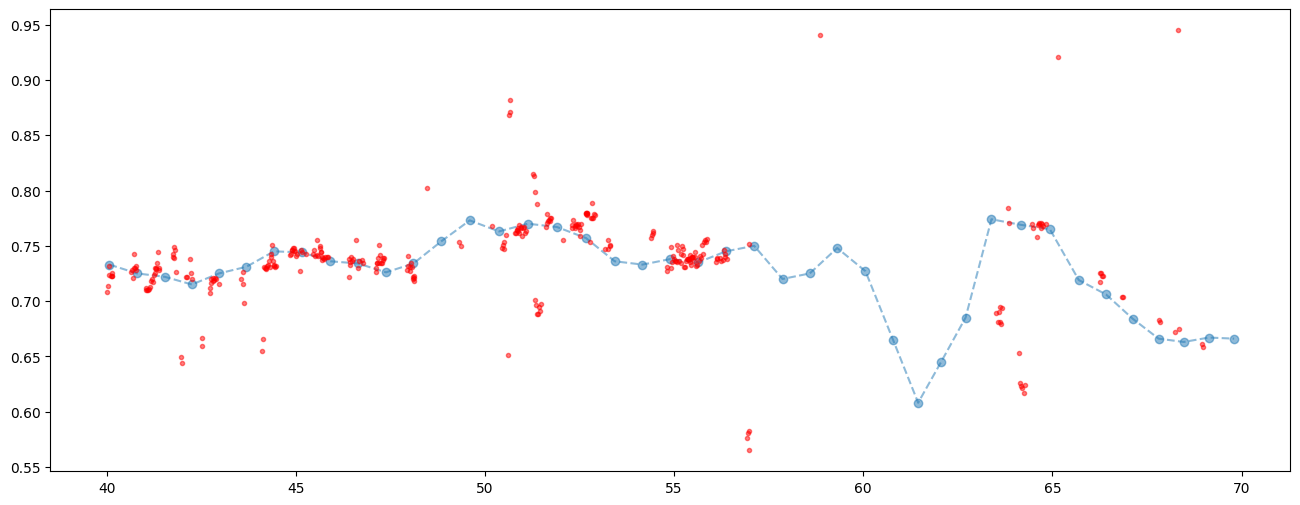

In [17]:
transparent_alpha=0.5  # 透明度の設定

# プロット
plt.figure(figsize=(16, 6))
plt.plot(ibiECG_time_cut, ibiECG_ibi_cut, '--o', label='ECG', alpha=transparent_alpha)
plt.plot(X, y, 'r.', label='Observed Data', alpha=transparent_alpha)
plt.plot(X_pred_gpy, y_pred_gpy, 'b.', label='Prediction', alpha=transparent_alpha)
plt.fill_between(
    X_pred_gpy.flatten(),
    (y_pred_gpy - 1.96 * np.sqrt(y_pred_gpy)).flatten(),
    (y_pred_gpy + 1.96 * np.sqrt(y_pred_gpy)).flatten(),
    color='blue',
    alpha=0.2,
    label='95% Confidence Interval'
)
plt.ylim(0.2, 1.4)  # y軸の範囲を設定
plt.legend()
plt.title('Robust Gaussian Process with Student-t Distribution')
plt.show()

In [46]:

# 精度評価
# RMSEの計算
radar_est_time = X_pred_gpy
radar_est_ibi = y_pred_gpy
ecg_time = ibiECG_time_cut
ecg_ibi = ibiECG_ibi_cut
[rmse, IBI_diff] = calc_rmse(radar_est_time, radar_est_ibi, ecg_time, ecg_ibi)
print(f"RMSE: {rmse*1e3:.2f} ms")
# TCRの計算
TCR_dt = 1
# ERROR_TIME = 50*1e-3
ERROR_TIME = 15*1e-3
tcr = calc_tcr(radar_est_time, radar_est_ibi, ecg_time, ecg_ibi, TCR_dt, ERROR_TIME)
print(f"TCR: {tcr:.2f} %")


RMSE: 20.13 ms
TCR: 48.28 %


TCR: 93.10 %


## scikit learn

In [42]:
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
from sklearn.gaussian_process.kernels import Matern

y_radar = this_ibi
X_radar = this_time.reshape(-1, 1)

# カーネルの定義（RBF + WhiteKernel + PeriodicKernel）
# カーネルの定義（Matern Kernel + WhiteKernel）
kernel_radar = (
    C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5) +
    WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e1))
)

# kernel_radar = (
#     C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5) +
#     WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e1))
# )


# kernel_radar = (
#     C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2)) +
#     WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e1)) +
#     ExpSineSquared(length_scale=1.0, periodicity=3.0, periodicity_bounds=(1.0, 10.0))
# )

# Gaussian Process Regressorの初期化
gp_radar = GaussianProcessRegressor(kernel=kernel_radar, n_restarts_optimizer=10)

# モデルの学習
gp_radar.fit(X_radar, y_radar)




GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-05),
                         n_restarts_optimizer=10)

In [51]:

# 予測用データの生成
x_time_min = X_radar.min()
x_time_max = X_radar.max()
# X_radar_pred_sklearn = np.arange(x_time_min, x_time_max + 1, 1).reshape(-1, 1)
X_radar_pred_sklearn = np.arange(x_time_min, x_time_max + 1, 0.01).reshape(-1, 1)

# 平均と標準偏差を予測
y_radar_pred_sklearn, sigma_radar_sklearn = gp_radar.predict(X_radar_pred_sklearn, return_std=True)



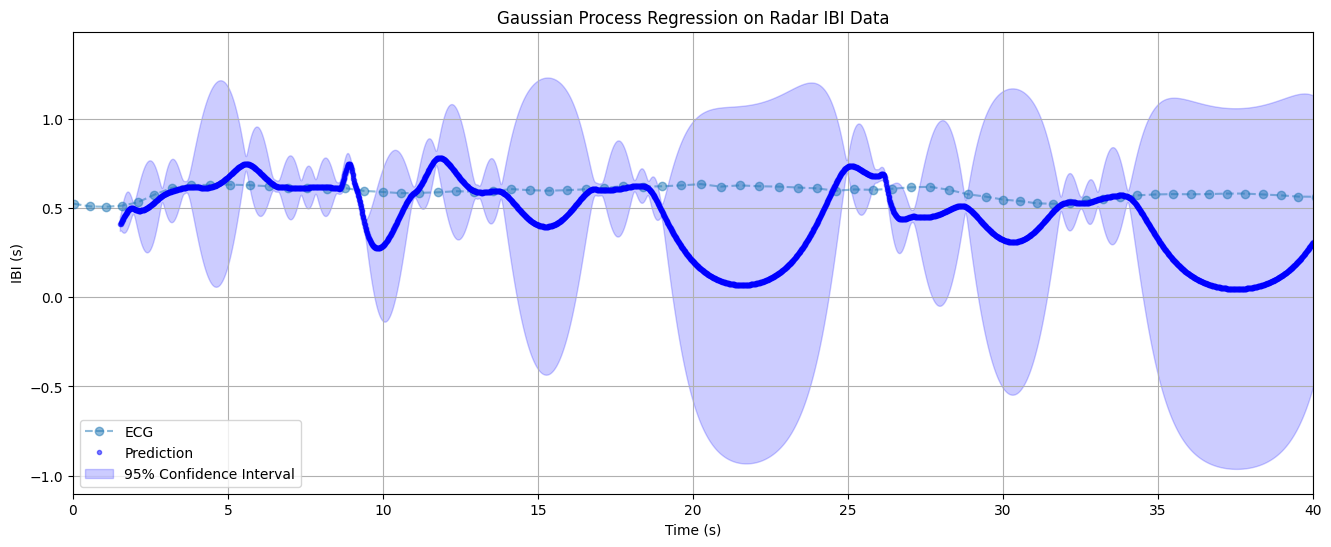

In [ ]:
XLim = np.array([0, 40])
# XLim = np.array([40, 80])
# XLim = np.array([80, 120])

# プロット
transparent_alpha = 0.5
plt.figure(figsize=(16, 6))
plt.plot(ibiECG_time_cut, ibiECG_ibi_cut, '--o', label='ECG', alpha=transparent_alpha)
# plt.plot(X_radar, y_radar, 'r.', markersize=3, label='Observed Data', alpha=transparent_alpha)
plt.plot(X_radar_pred_sklearn, y_radar_pred_sklearn, 'b.', label='Prediction', alpha=transparent_alpha)
plt.fill_between(
    X_radar_pred_sklearn.ravel(),
    y_radar_pred_sklearn - 1.96 * sigma_radar_sklearn,
    y_radar_pred_sklearn + 1.96 * sigma_radar_sklearn,
    alpha=0.2,
    color='blue',
    label='95% Confidence Interval'
)
plt.xlabel('Time (s)')
plt.ylabel('IBI (s)')
plt.legend()
plt.title('Gaussian Process Regression on Radar IBI Data')
plt.grid()
plt.xlim(XLim)  # y軸の範囲を設定
plt.show()

In [49]:
# 精度評価
# RMSEの計算
radar_est_time = X_radar_pred_sklearn.ravel()
radar_est_ibi = y_radar_pred_sklearn.ravel()
ecg_time = ibiECG_time_cut.ravel()
ecg_ibi = ibiECG_ibi_cut.ravel()
[rmse, IBI_diff] = calc_rmse(radar_est_time, radar_est_ibi, ecg_time, ecg_ibi)
print(f"RMSE: {rmse*1e3:.2f} ms")
# TCR
TCR_dt = 1
# ERROR_TIME = 50*1e-3
ERROR_TIME = 15*1e-3
tcr = calc_tcr(radar_est_time, radar_est_ibi, ecg_time, ecg_ibi, TCR_dt, ERROR_TIME)
print(f"TCR: {tcr:.2f} %")


RMSE: 190.11 ms
TCR: 22.01 %


(955,)


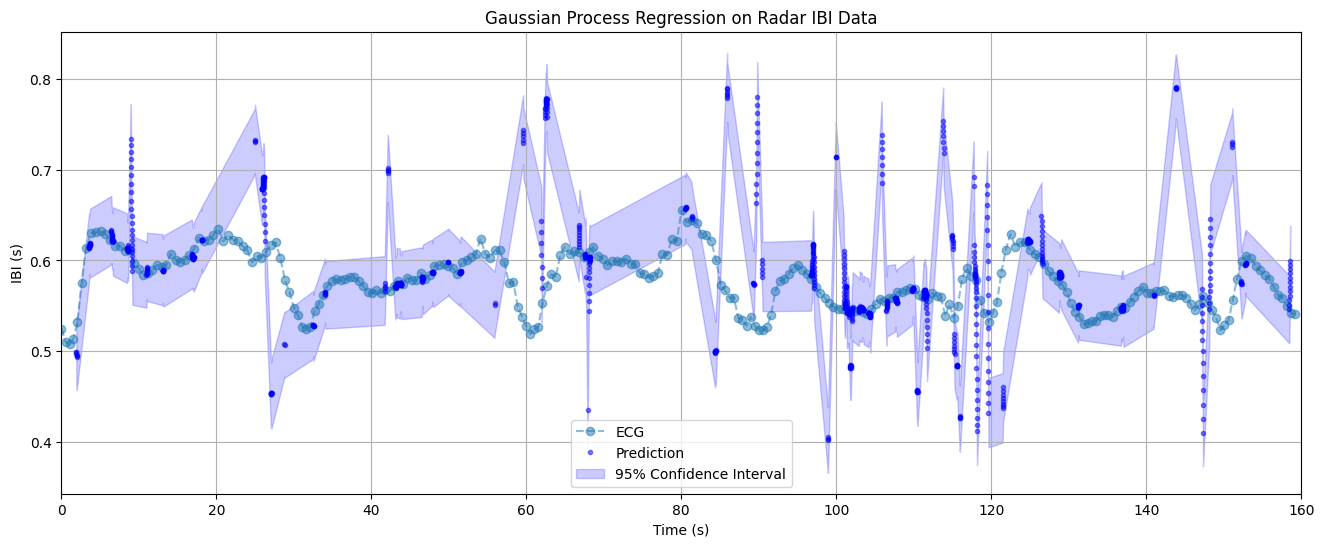

In [ ]:
outlier_ibi_thre_s = 20*1e-3

# sigma_radar_sklearnがoutlier_ibi_thre_s以下のindexを取得
valid_idx = np.where(sigma_radar_sklearn <= outlier_ibi_thre_s)[0]
X_radar_pred_sklearn_cut = X_radar_pred_sklearn[valid_idx]
y_radar_pred_sklearn_cut = y_radar_pred_sklearn[valid_idx]
sigma_radar_sklearn_cut = sigma_radar_sklearn[valid_idx]
print(sigma_radar_sklearn_cut.shape)

XLim = np.array([0, 160])
# XLim = np.array([0, 40])
# XLim = np.array([40, 80])
# XLim = np.array([80, 120])

# プロット
transparent_alpha = 0.5
plt.figure(figsize=(16, 6))
plt.plot(ibiECG_time_cut, ibiECG_ibi_cut, '--o', label='ECG', alpha=transparent_alpha)
# plt.plot(X_radar, y_radar, 'r.', markersize=3, label='Observed Data', alpha=transparent_alpha)
plt.plot(X_radar_pred_sklearn_cut, y_radar_pred_sklearn_cut, 'b.', label='Prediction', alpha=transparent_alpha)
plt.fill_between(


    
    X_radar_pred_sklearn_cut.ravel(),
    y_radar_pred_sklearn_cut - 1.96 * sigma_radar_sklearn_cut,
    y_radar_pred_sklearn_cut + 1.96 * sigma_radar_sklearn_cut,
    alpha=0.2,
    color='blue',
    label='95% Confidence Interval'
)
plt.xlabel('Time (s)')
plt.ylabel('IBI (s)')
plt.legend()
plt.title('Gaussian Process Regression on Radar IBI Data')
plt.grid()
plt.xlim(XLim)  # y軸の範囲を設定
plt.show()

In [ ]:
# 精度評価
# RMSEの計算
radar_est_time = X_radar_pred_sklearn.ravel()
radar_est_ibi = y_radar_pred_sklearn.ravel()
ecg_time = ibiECG_time_cut.ravel()
ecg_ibi = ibiECG_ibi_cut.ravel()
[rmse, IBI_diff] = calc_rmse(radar_est_time, radar_est_ibi, ecg_time, ecg_ibi)
print(f"RMSE: {rmse*1e3:.2f} ms")
# TCR
TCR_dt = 1
# ERROR_TIME = 50*1e-3
ERROR_TIME = 15*1e-3
tcr = calc_tcr(radar_est_time, radar_est_ibi, ecg_time, ecg_ibi, TCR_dt, ERROR_TIME)
print(f"TCR: {tcr:.2f} %")

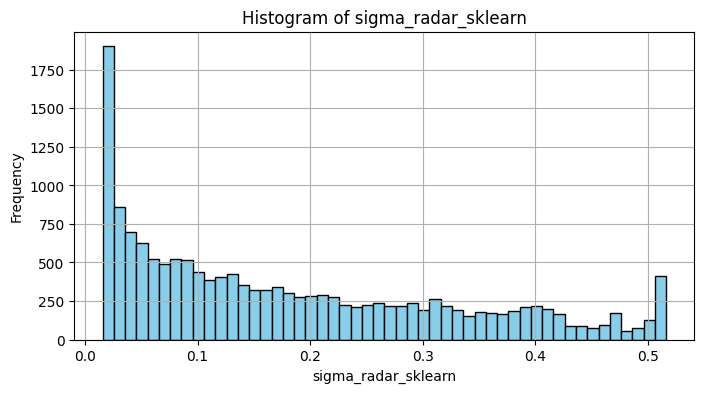

In [67]:
plt.figure(figsize=(8, 4))
plt.hist(sigma_radar_sklearn, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('sigma_radar_sklearn')
plt.ylabel('Frequency')
plt.title('Histogram of sigma_radar_sklearn')
plt.grid(True)
plt.show()

In [69]:
sigma_radar_sklearn

array([0.02082555, 0.02119593, 0.02256592, ..., 0.3795963 , 0.38190249,
       0.38417577])

In [40]:
X_radar_pred_sklearn[0]


array([40.007])

In [39]:
y_radar_pred_sklearn[0,0]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed